# Running the Luminosity-Temperature-Radius pipeline

We will use the XGA LTR pipeline to try to determine overdensity radii, and the global temperature and luminosity measurements within them. This process is [fully described here](https://xga.readthedocs.io/en/latest/notebooks/pipeline_tutorials/LT_pipeline.html). This should be relatively successful, even given the low surface brightness of the groups, as it easier to get temperature constraints on lower-temperature systems than hotter systems when using XMM.

## Import statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
import os
from shutil import rmtree

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 20
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/lum_temp_rad_pipeline')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.tools import luminosity_temperature_pipeline
from xga.relations.clusters.RT import arnaud_r2500

%matplotlib inline

## Reading the sample file

Reading in the positions, names, and redshifts of the groups - the pipeline expects position columns to be called 'ra' and 'dec', so those are renamed:

In [2]:
samp = pd.read_csv('../../sample_files/init_group_info.csv')
samp = samp.rename(columns={'est_ra': 'ra', 'est_dec': 'dec'})
samp

,name,ra,dec,redshift
0,25124,243.629055,26.730240,0.186
1,44739,229.793620,28.331750,0.118
2,19670A,150.256710,50.793942,0.134
3,19670B,150.214920,50.805014,0.134
4,12833,129.496800,44.248700,0.145
5,44858,230.112000,28.887750,0.127
6,PHL1811,328.769920,-9.588805,0.077
7,50433,157.732000,30.844000,0.136


## Running the pipeline (twice)

The LTR will be run twice, targeting two different overdensity radii. The pipeline runs will save the results to disk (as we are passing paths for the results and radii history files), as well as returning the results and the XGA ClusterSample object generated by the procedure.

### $R_{500}$

The first overdensity radius we are targeting is $R_{500}$, which is the default for this pipeline. The Arnaud et al. (2005) $R_{500}$-$T_{\rm{X}}$ is used for the process, and the starting radius is set to 200 kpc. Metallicity, nH, and redshift are all frozen during the spectral fitting process.

In [3]:
res_file = '../../outputs/results/ltr_r500_pipeline_results.csv'
rhist_file = '../../outputs/results/radii_r500_history.csv'

srcs, results, rad_hist = luminosity_temperature_pipeline(samp, Quantity(200, 'kpc'), timeout=Quantity(4, 'hr'), 
                                                          save_samp_results_path=res_file,
                                                          save_rad_history_path=rhist_file, 
                                                          core_excised=True, lo_en=Quantity(0.5, 'keV'), 
                                                          hi_en=Quantity(2.5, 'keV'))

Generating products of type(s) expmap: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:246: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()
Running XSPEC Fits: 100%|██████████| 8/8 [00:40<00:00,  5.09s/it]
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:608: UserWarning: There are no XSPEC fits associated with 50433
  warn(str(err))
Running XSPEC Fits: 100%|██████████| 7/7 [00:29<00:00,  4.16s/it]


### $R_{2500}$

The other overdensity radius we are targeting is $R_{2500}$. The Arnaud et al. (2005) $R_{2500}$-$T_{\rm{X}}$ is used for the process. As the ClusterSample in this run is completely separate from the $R_{500}$ run, it is possible that slightly different regions have been selected as contaminating sources, this would be due to XGA ClusterSamples allowing point sources in the core region to not be masked out, in case they are misidentified cool-cores.

In [4]:
res_file = '../../outputs/results/ltr_r2500_pipeline_results.csv'
rhist_file = '../../outputs/results/radii_r2500_history.csv'

srcs_r2500, results_r2500, \
    rad_hist_r2500 = luminosity_temperature_pipeline(samp, Quantity(200, 'kpc'), timeout=Quantity(4, 'hr'), 
                                                     rad_temp_rel=arnaud_r2500, save_samp_results_path=res_file,
                                                     save_rad_history_path=rhist_file, lo_en=Quantity(0.5, 'keV'), 
                                                          hi_en=Quantity(2.5, 'keV'))

Setting up Galaxy Clusters: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:246: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()
Running XSPEC Fits: 100%|██████████| 8/8 [00:39<00:00,  4.88s/it]
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:608: UserWarning: There are no XSPEC fits associated with 50433
  warn(str(err))
Running XSPEC Fits: 100%|██████████| 7/7 [01:24<00:00, 12.09s/it]
/mnt/ufs18/home-218/turne540/code/XGA/xga/products/relation.py:704: UserWarning: Some of the x values you have passed are outside the validity range of this relation (1.0-12.0keV).
  warn("Some of the x values you have passed are outside the validity range of this relation "
Running XSPEC Fits: 100%|██████████| 2/2 [00:17<00:00,  8.63s/it]


### $R_{500}$ - with metallicity free

The first overdensity radius we are targeting is $R_{500}$, which is the default for this pipeline. The Arnaud et al. (2005) $R_{500}$-$T_{\rm{X}}$ is used for the process, and the starting radius is set to 200 kpc. nH, and redshift are all frozen during the spectral fitting process.

In [5]:
res_file = '../../outputs/results/ltr_r500_metfree_pipeline_results.csv'
rhist_file = '../../outputs/results/radii_metfree_r500_history.csv'

srcs_metfree, results_metfree, rad_hist_metfree = luminosity_temperature_pipeline(samp, Quantity(200, 'kpc'), 
                                                                                  timeout=Quantity(4, 'hr'), 
                                                                                  save_samp_results_path=res_file, 
                                                                                  save_rad_history_path=rhist_file, 
                                                                                  core_excised=True, freeze_met=False, lo_en=Quantity(0.5, 'keV'), 
                                                          hi_en=Quantity(2.5, 'keV'))

Setting up Galaxy Clusters: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:246: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()
Running XSPEC Fits: 100%|██████████| 8/8 [01:36<00:00, 12.11s/it]
/mnt/ufs18/home-218/turne540/code/XGA/xga/products/relation.py:704: UserWarning: Some of the x values you have passed are outside the validity range of this relation (1.0-12.0keV).
  warn("Some of the x values you have passed are outside the validity range of this relation "
Running XSPEC Fits: 100%|██████████| 8/8 [00:47<00:00,  5.92s/it]
/mnt/ufs18/home-218/turne540/code/XGA/xga/products/relation.py:704: UserWarning: Some of the x values you have passed are outside the validity range of this relation (1.0-12.0keV).
  warn("Some of the x values you have passed are outside the validity range of thi

### $R_{2500}$ - with metallicity free

The other overdensity radius we are targeting is $R_{2500}$. The Arnaud et al. (2005) $R_{2500}$-$T_{\rm{X}}$ is used for the process. As the ClusterSample in this run is completely separate from the $R_{500}$ run, it is possible that slightly different regions have been selected as contaminating sources, this would be due to XGA ClusterSamples allowing point sources in the core region to not be masked out, in case they are misidentified cool-cores.

In [6]:
res_file = '../../outputs/results/ltr_r2500_metfree_pipeline_results.csv'
rhist_file = '../../outputs/results/radii_r2500_metfree_history.csv'

srcs_r2500_metfree, results_r2500_metfree, \
    rad_hist_r2500_metfree = luminosity_temperature_pipeline(samp, Quantity(200, 'kpc'), timeout=Quantity(4, 'hr'), 
                                                             rad_temp_rel=arnaud_r2500, 
                                                             save_samp_results_path=res_file,
                                                             save_rad_history_path=rhist_file,
                                                             freeze_met=False, lo_en=Quantity(0.5, 'keV'), 
                                                          hi_en=Quantity(2.5, 'keV'))

Setting up Galaxy Clusters: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:246: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()
Running XSPEC Fits: 100%|██████████| 8/8 [01:36<00:00, 12.05s/it]
/mnt/ufs18/home-218/turne540/code/XGA/xga/products/relation.py:704: UserWarning: Some of the x values you have passed are outside the validity range of this relation (1.0-12.0keV).
  warn("Some of the x values you have passed are outside the validity range of this relation "
Running XSPEC Fits: 100%|██████████| 8/8 [02:02<00:00, 15.35s/it]
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:608: UserWarning: Those spectra have no associated XSPEC fit to 19670A
  warn(str(err))
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:608: UserWarning: Those spectra have no associated 

## Examining the spectra

### $R_{500}$

In [11]:
print(srcs.r500[0])
print(srcs[0].r500)

923.6832610920303 kpc
923.6832610920301 kpc


In [16]:
srcs[0].convert_radius(srcs[0].r500, 'arcsec')

<Quantity 296.45791248 arcsec>

25124 923.68 kpc
0900700101 pn


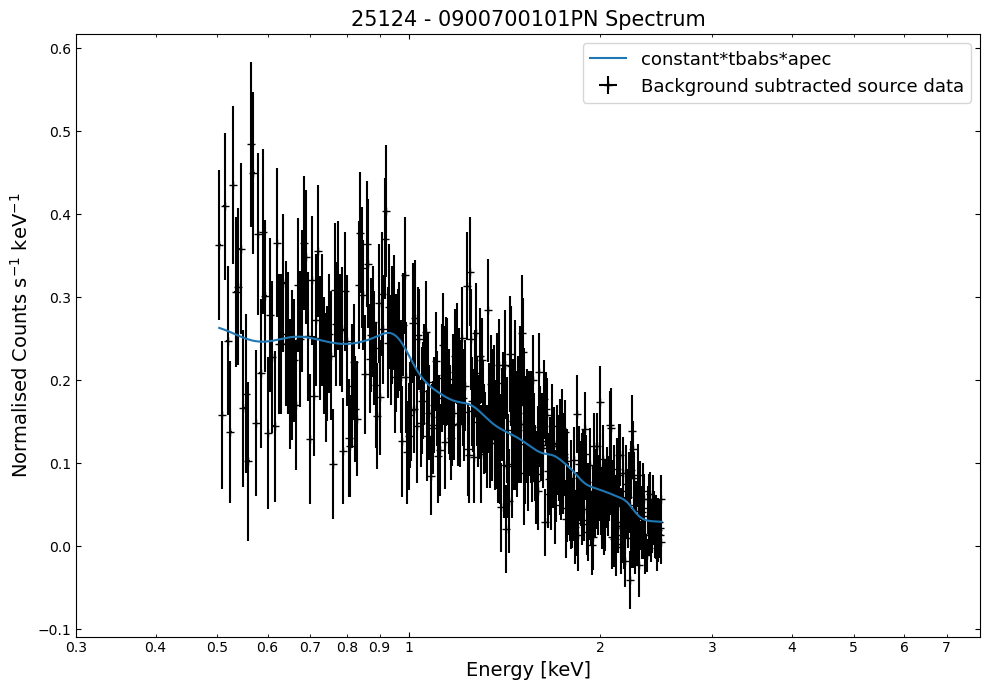

0900700101 mos2


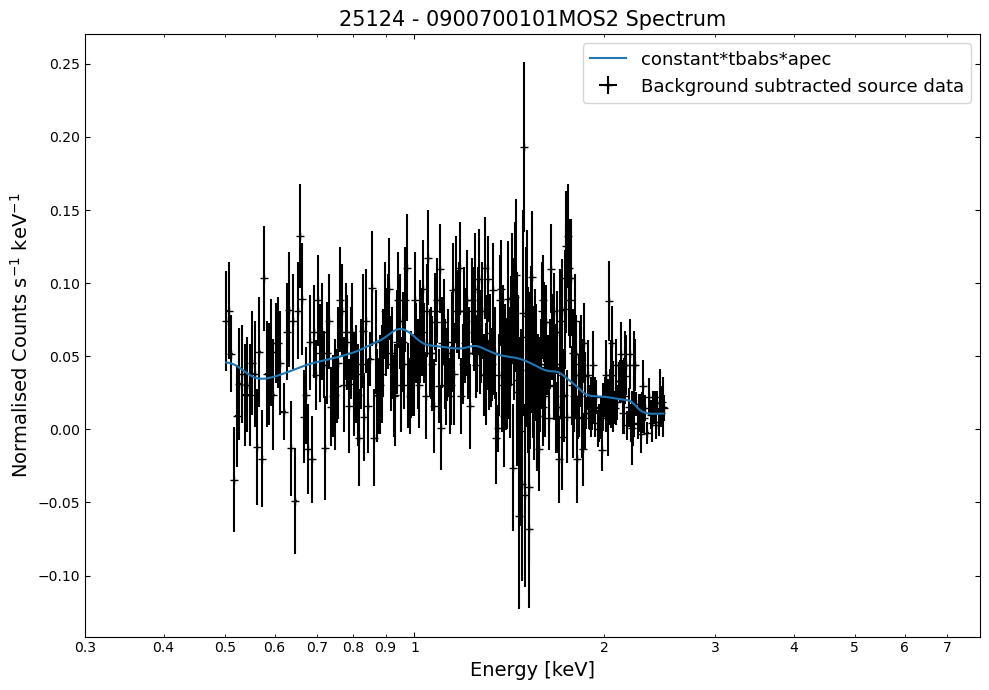





44739 424.25 kpc
0900700201 pn


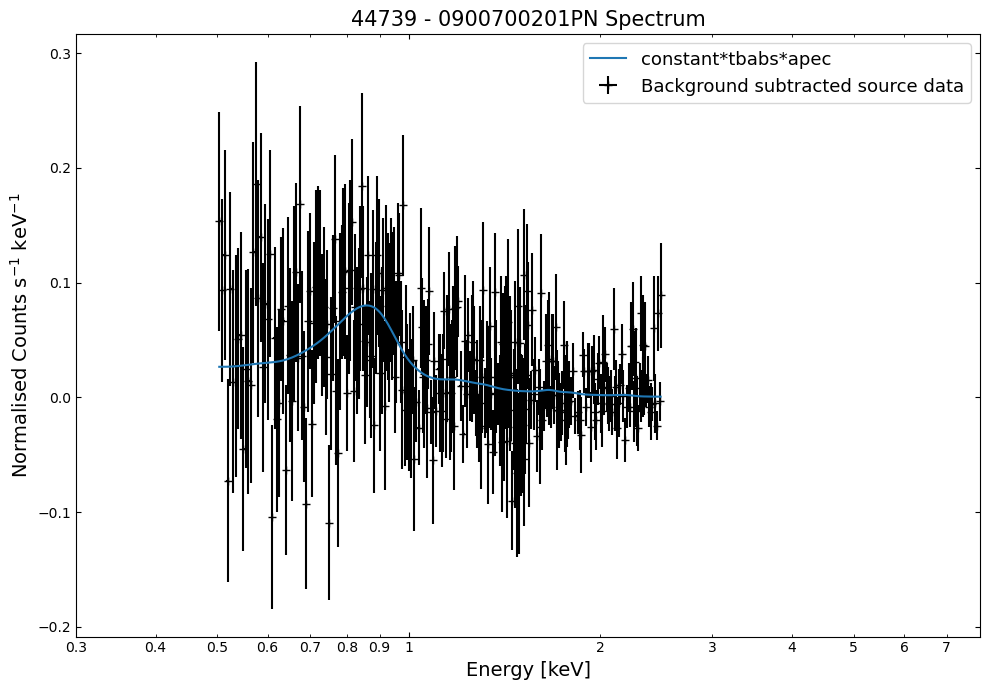

0900700201 mos1


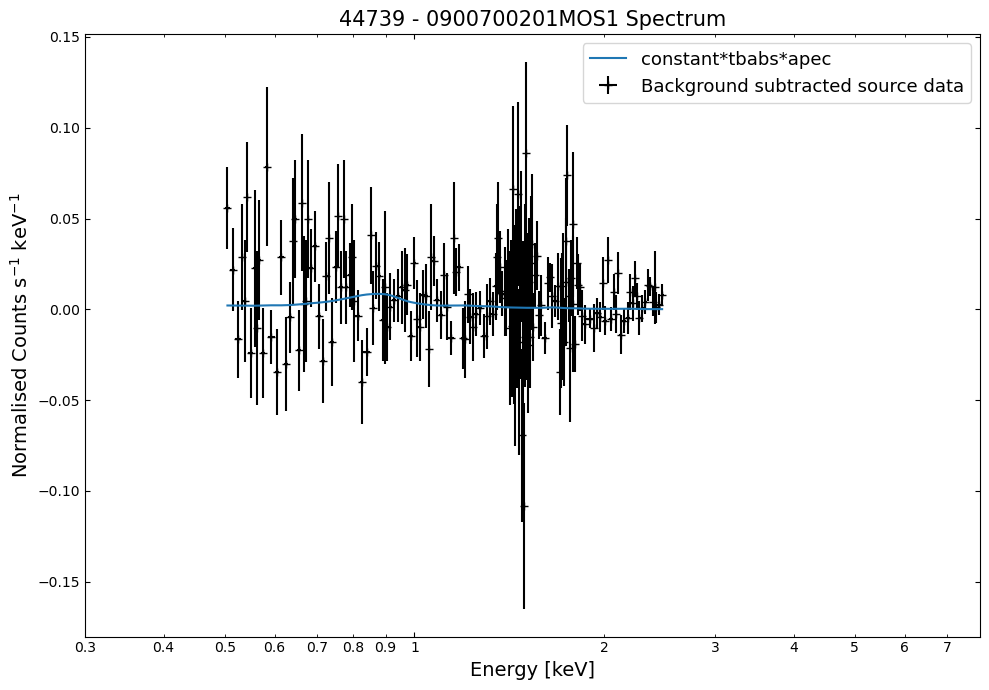

0900700201 mos2


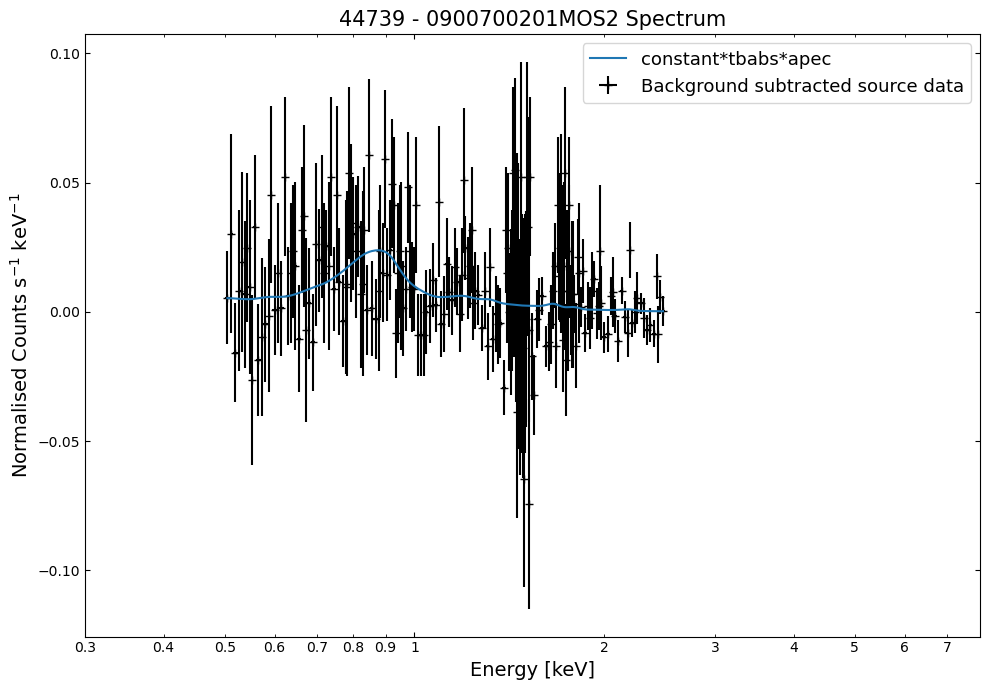





19670A 461.74 kpc
0861080101 pn


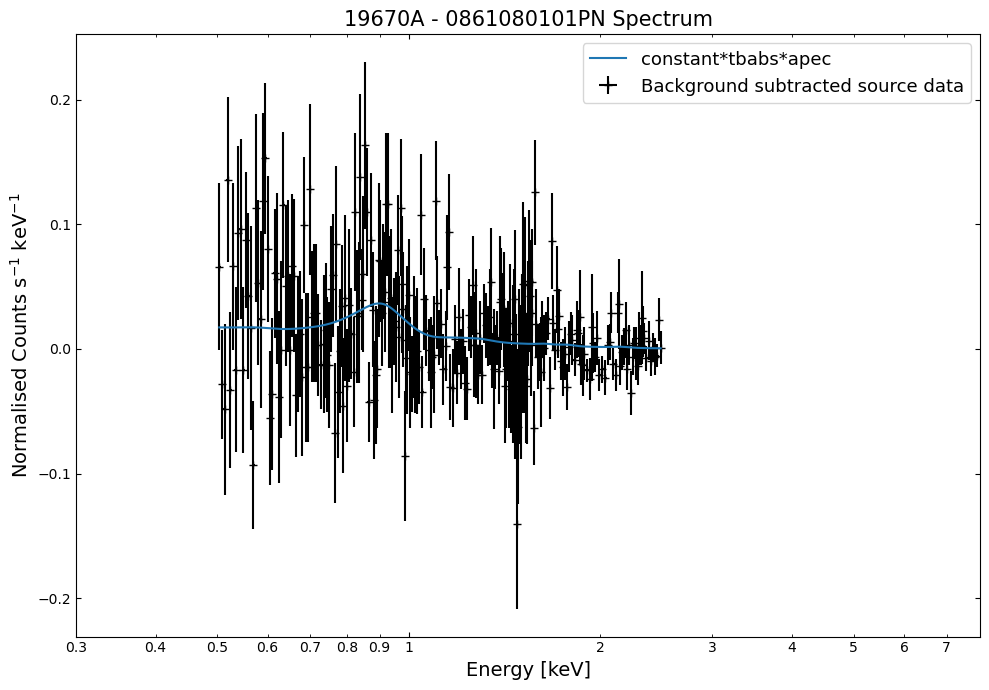

0861080101 mos1


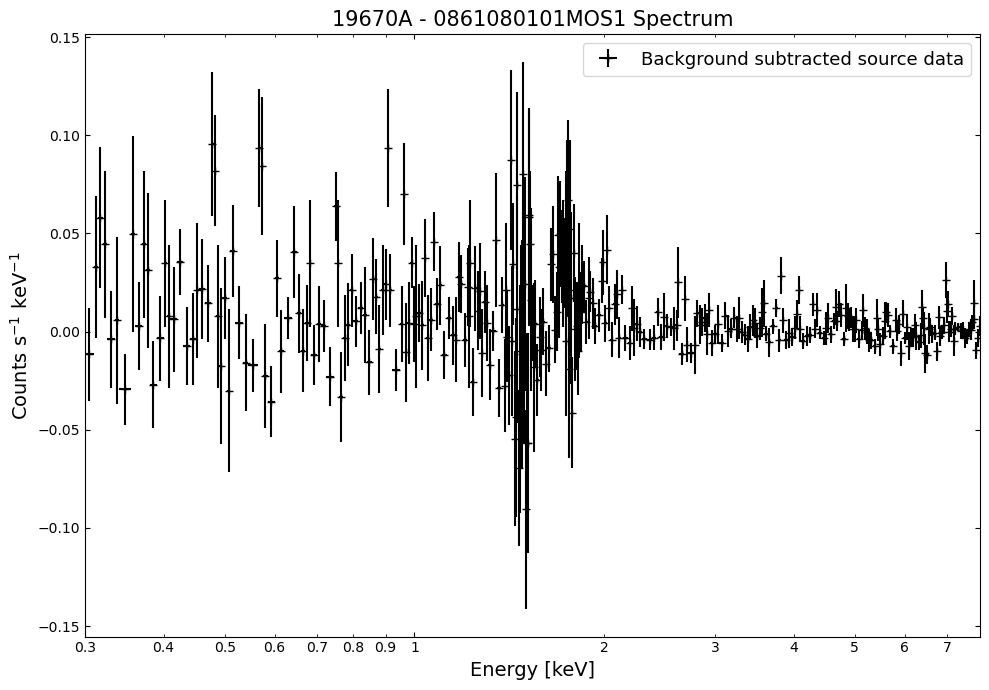

0861080101 mos2


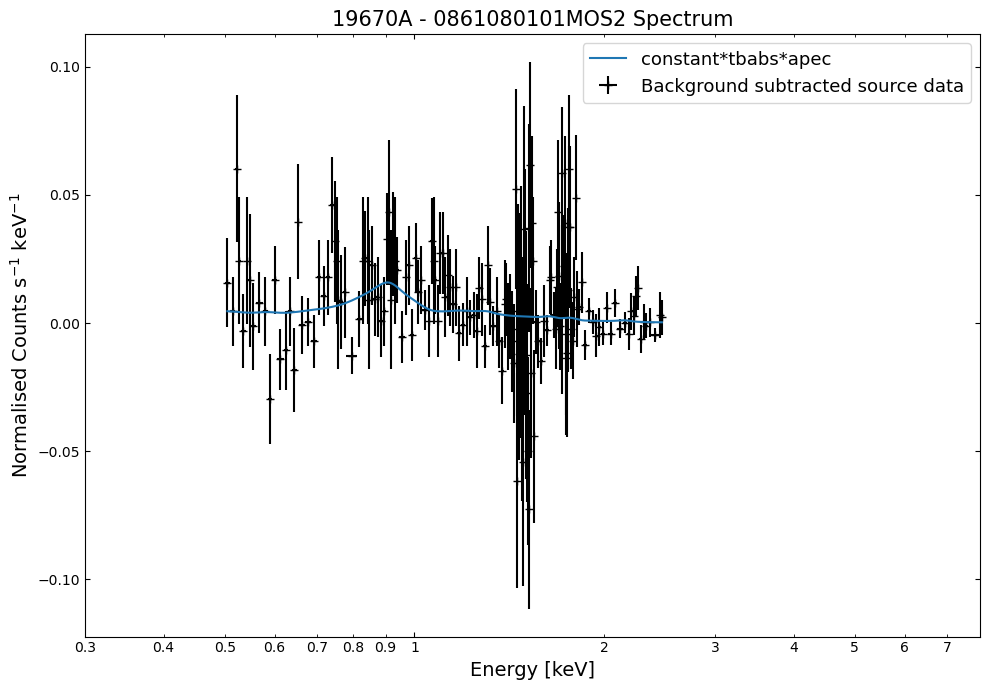





19670B 557.52 kpc
0861080101 pn


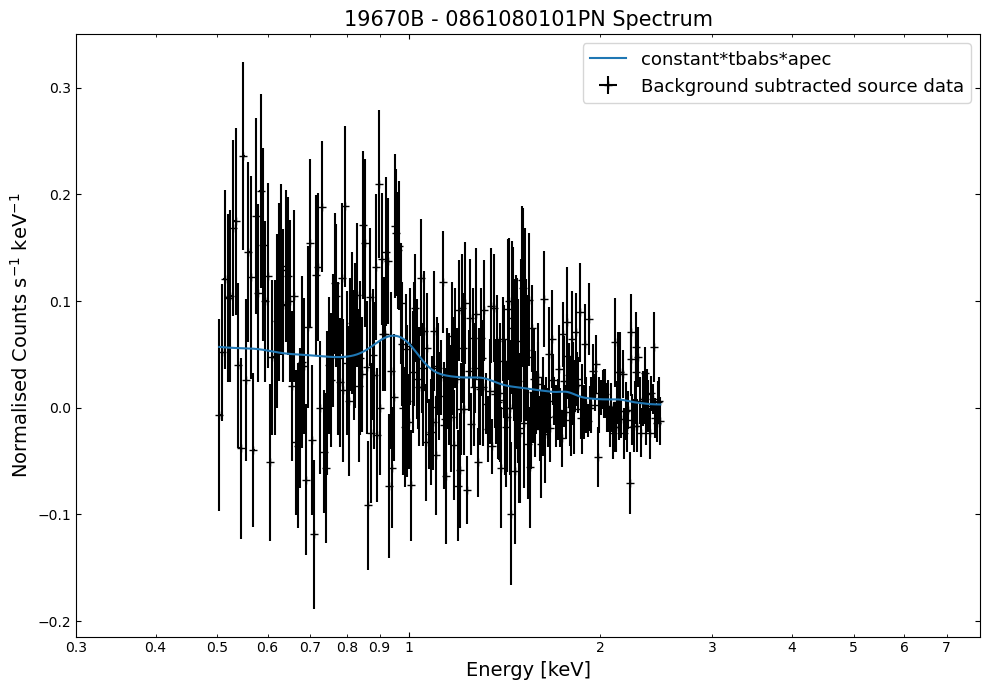

0861080101 mos1


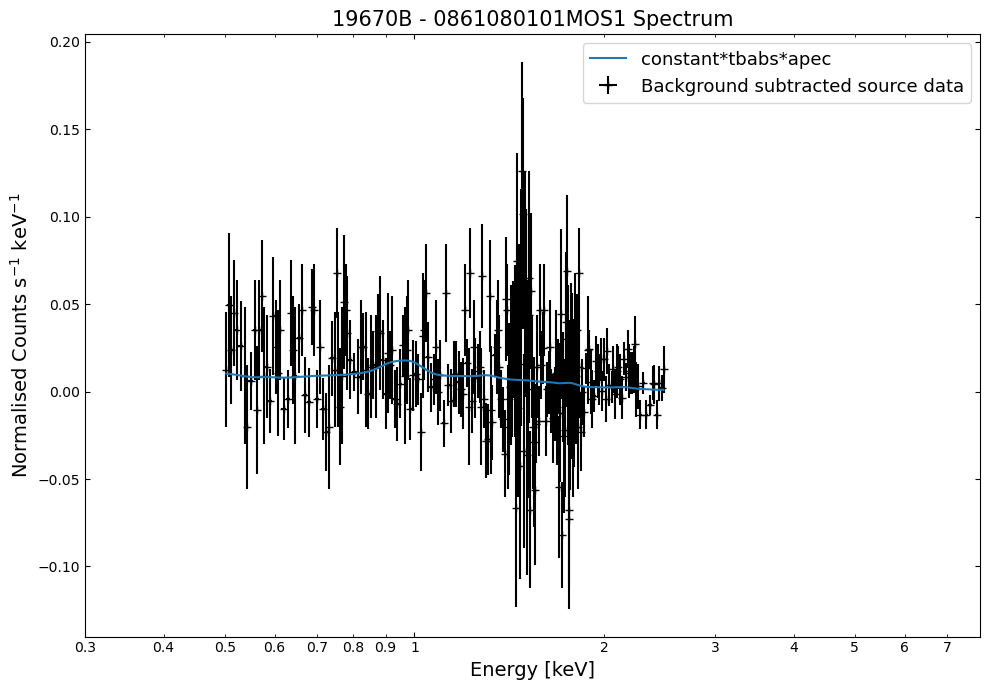

0861080101 mos2


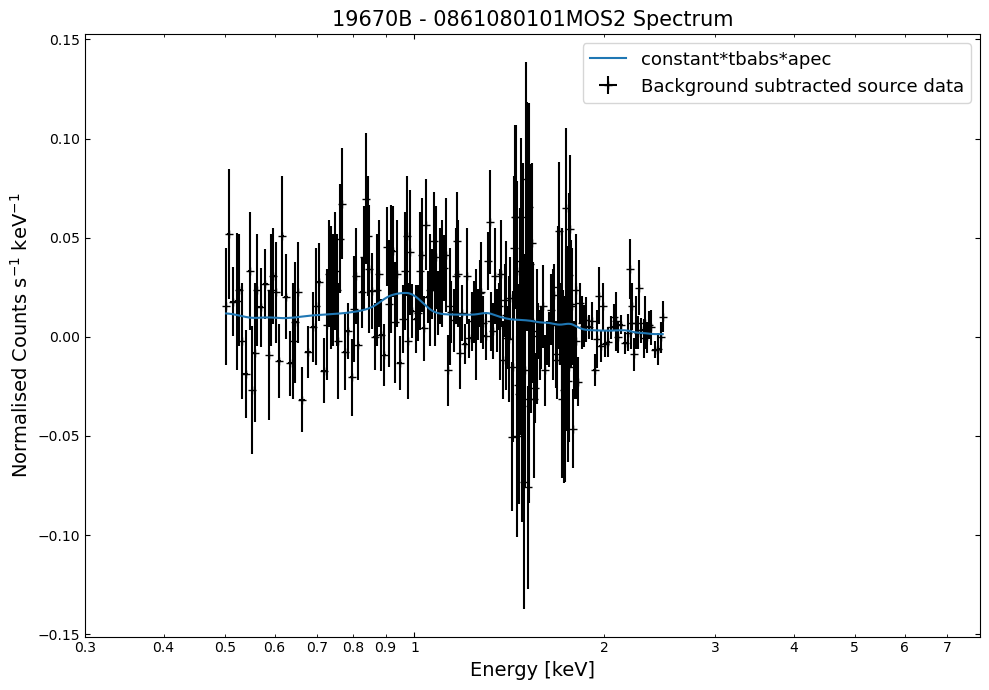





12833 487.61 kpc
0861080201 pn


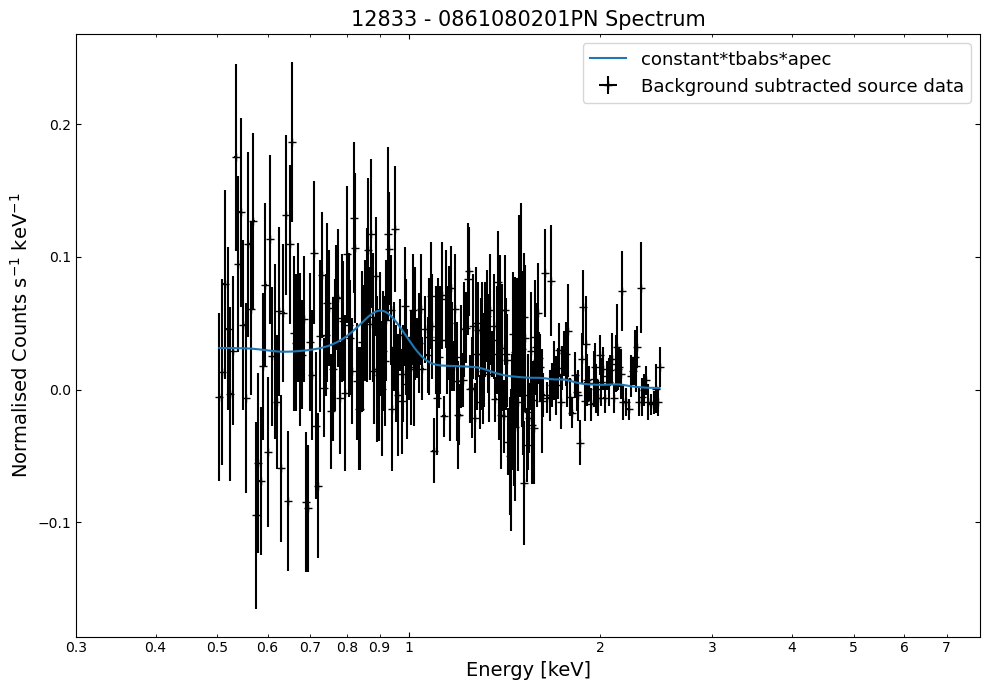

0861080201 mos1


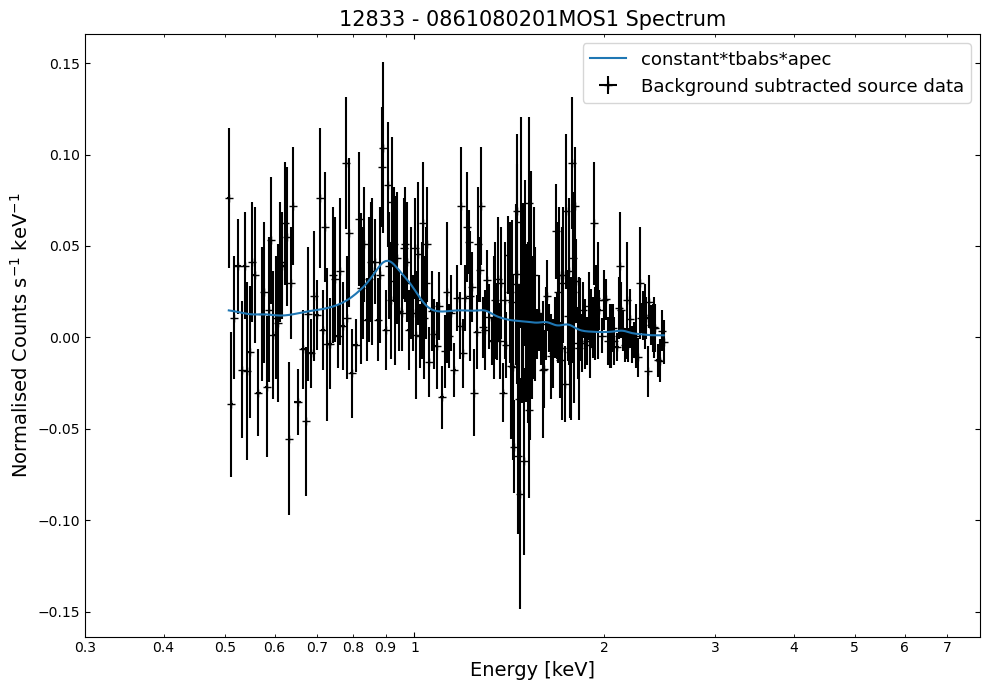

0861080201 mos2


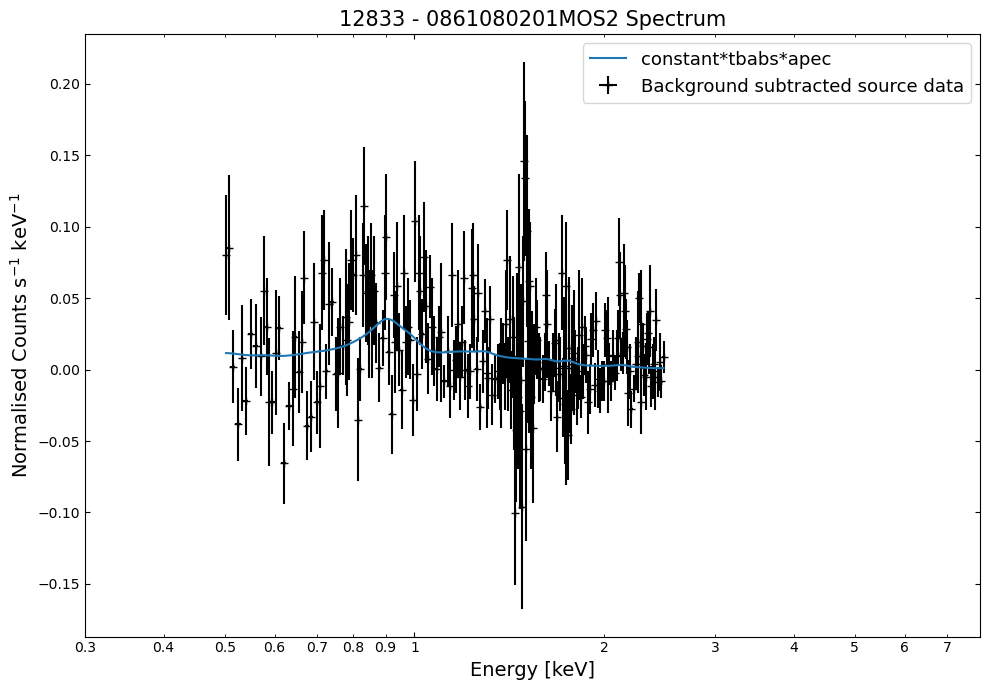





44858 623.83 kpc
0820240301 pn


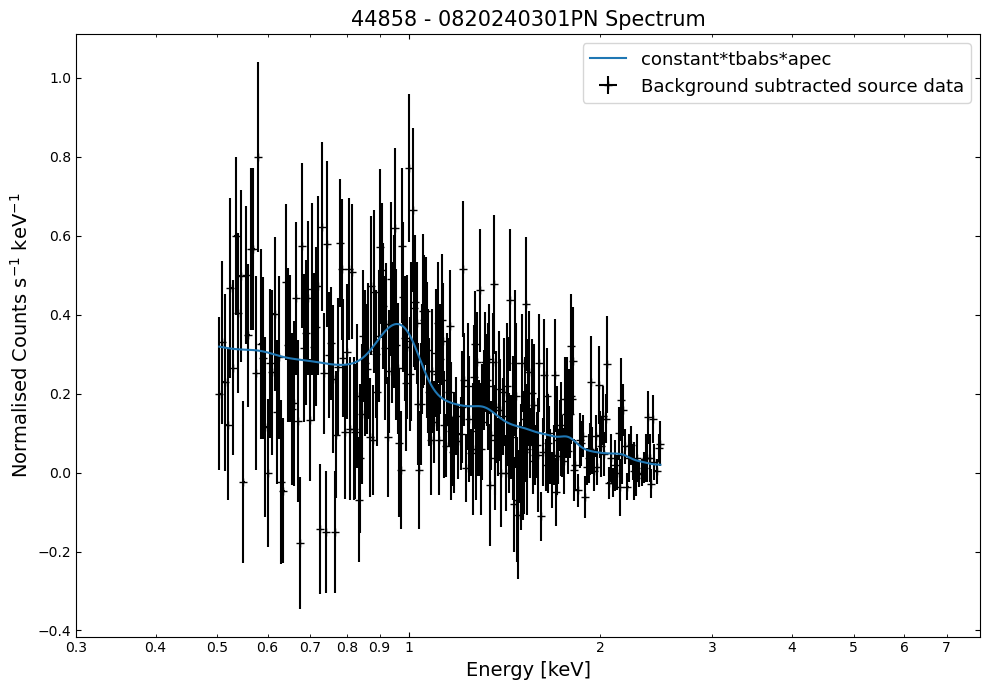

0820240301 mos1


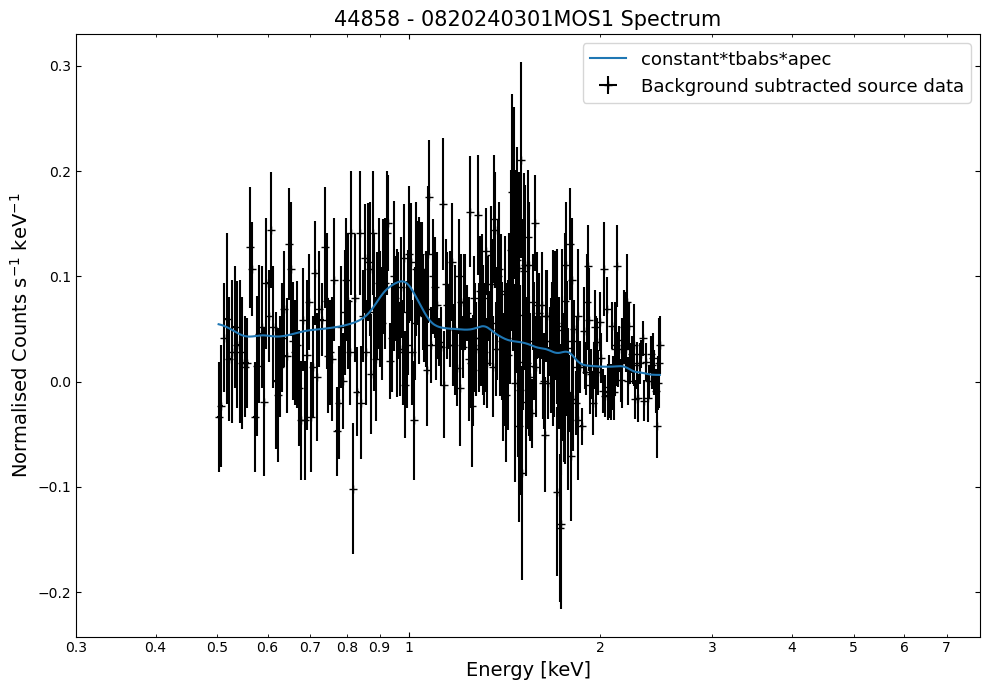

0820240301 mos2


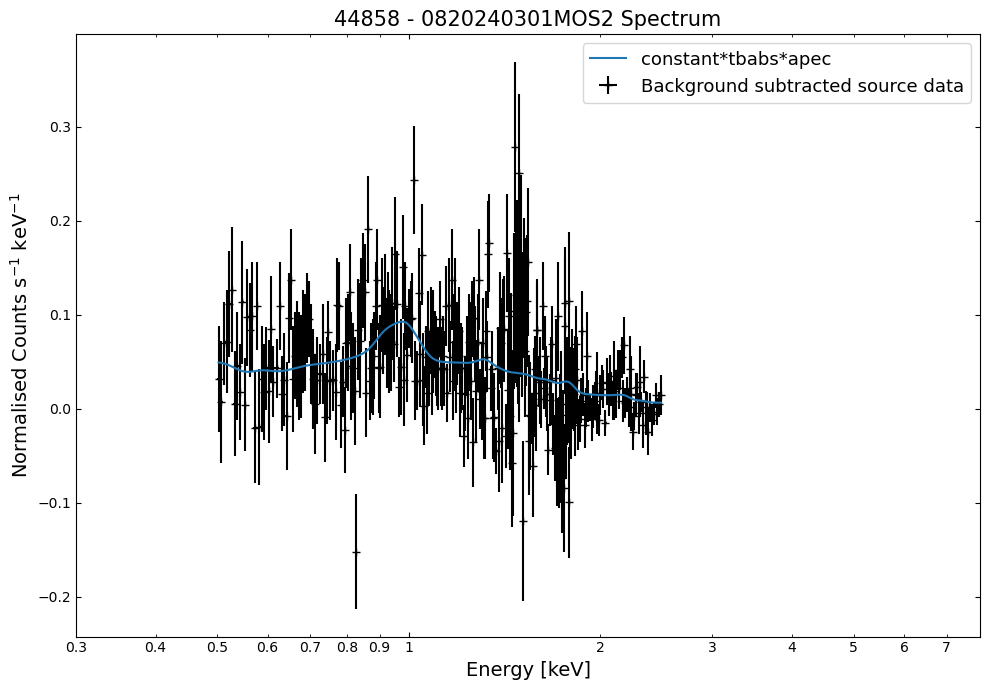





PHL1811 569.6 kpc
0204310101 mos1


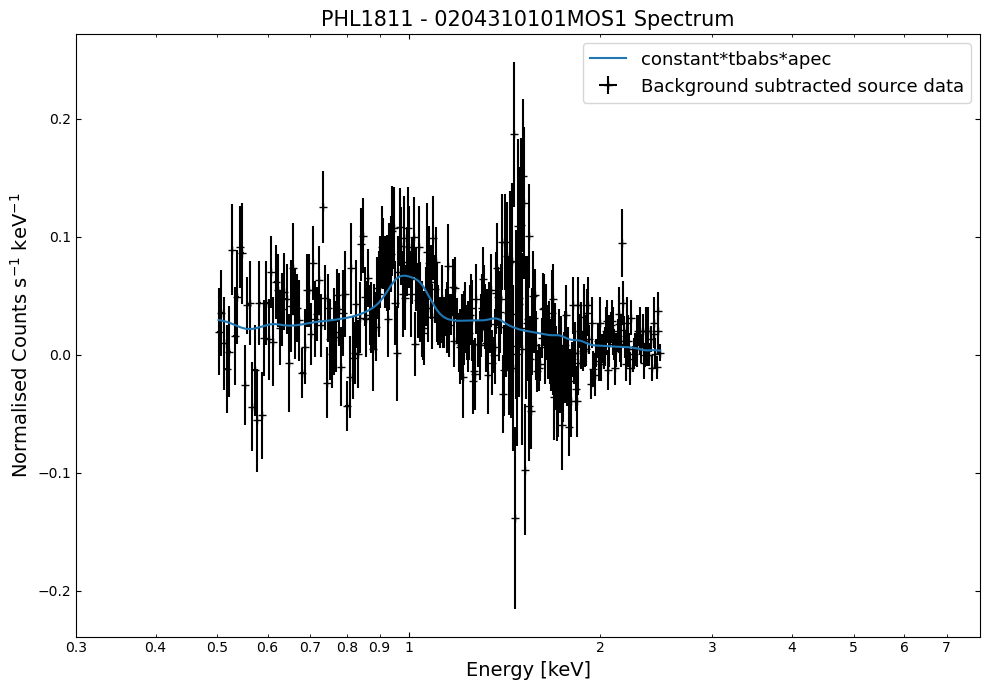

0204310101 mos2


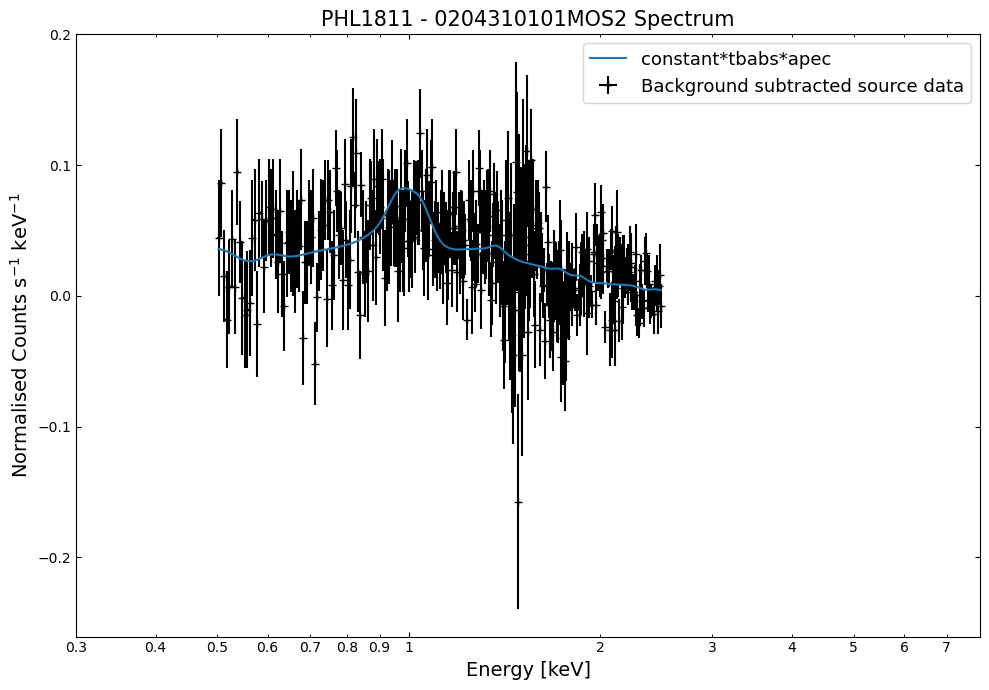

0761910201 mos2


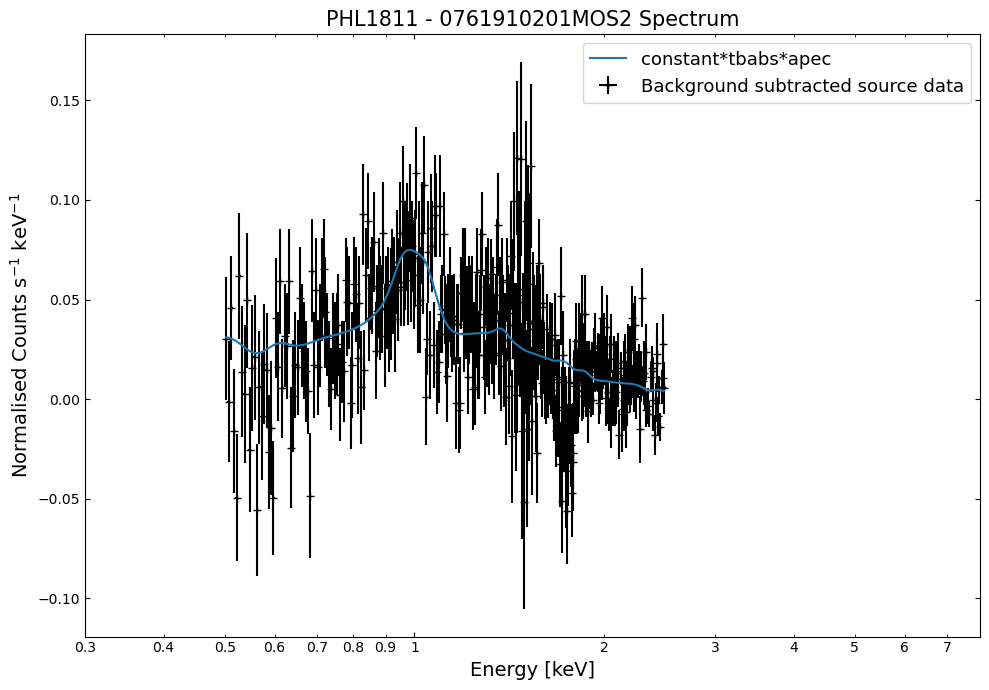

In [20]:
for src_ind, src in enumerate(srcs):
    print(src.name, src.r500.round(2))

    for sp in src.get_spectra(srcs.r500[src_ind]):
        print(sp.obs_id, sp.instrument)
        sp.view(show_model_fits=True)

    print('\n\n\n')

### $R_{500}$ - with metallicity free

In [ ]:
for src in srcs_metfree:
    print(src.name, src.r500)
    for sp in src.get_spectra(src.r500):
        print(sp.obs_id, sp.instrument)
        sp.view()
    print('\n\n\n')

### $R_{2500}$

In [ ]:
for src in srcs_r2500:
    print(src.name, src.r2500)
    for sp in src.get_spectra(src.r2500):
        print(sp.obs_id, sp.instrument)
        sp.view()
    print('\n\n\n')

### $R_{2500}$ - with metallicity free

In [ ]:
for src in srcs_r2500_metfree:
    print(src.name, src.r2500)
    for sp in src.get_spectra(src.r2500):
        print(sp.obs_id, sp.instrument)
        sp.view()
    print('\n\n\n')

## Pipeline results

We take a look at the tables of results output by the pipeline runs:

### $R_{500}$

In [ ]:
results

In [ ]:
rad_hist

### $R_{500}$ - with metallicity free

In [ ]:
results_metfree

In [ ]:
rad_hist_metfree

### $R_{2500}$

In [ ]:
results_r2500

In [ ]:
rad_hist_r2500

### $R_{2500}$ - with metallicity free

In [ ]:
results_r2500_metfree

In [ ]:
rad_hist_r2500_metfree